# **Install important liberaries**

In [ ]:
!pip install transformers datasets evaluate
!pip install wordcloud
!pip install nltk
!pip install palettable
!pip install clean-text
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

# **Libraries**

In [ ]:
from transformers import RobertaTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import re
import torch
from functools import partial
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from datasets import load_dataset
import matplotlib.pyplot as plt
from cleantext import clean
import string
import pickle

# **load dataset**

In [ ]:
dataset = pd.read_csv('/content/Emotion_final.csv')

In [ ]:
dataset.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# **Exploratory Data Analysis**

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [ ]:
pd.DataFrame(dataset['Emotion'].value_counts()).rename(columns={'Emotion': 'Count'})

,count
Emotion,
happy,7029
sadness,6265
anger,2993
fear,2652
love,1641
surprise,879


**Number of duplicate sentence**

In [ ]:
pd.DataFrame({'Count': [dataset['Text'].duplicated().sum()]})

,Count
0,54


**Remove duplicate data**

In [ ]:
dataset.drop_duplicates(subset='Text', inplace=True)
dataset.dropna(subset=['Text'], inplace=True)

**Number of duplicate sentence after remove it**



In [ ]:
pd.DataFrame({'Count': [dataset['Text'].duplicated().sum()]})

,Count
0,0


**Emotional Distribution and Frequency**

In [ ]:
pd.DataFrame(dataset['Emotion'].value_counts()).rename(columns={'Emotion': 'Count'})

,count
Emotion,
happy,7008
sadness,6261
anger,2986
fear,2647
love,1630
surprise,873


**build class to make visualization to data:**

The `Analysis` class visualizes and summarizes categorical data from a pandas DataFrame. It initializes with a customizable figure size, and offers methods to plot bar and pie charts, create a summary DataFrame of counts, and display both charts and summaries via a callable interface.



-------------------------------------------------------


,0,1,2,3,4,5
emotion,happy,sadness,anger,fear,love,surprise
count,7008,6261,2986,2647,1630,873


-------------------------------------------------------


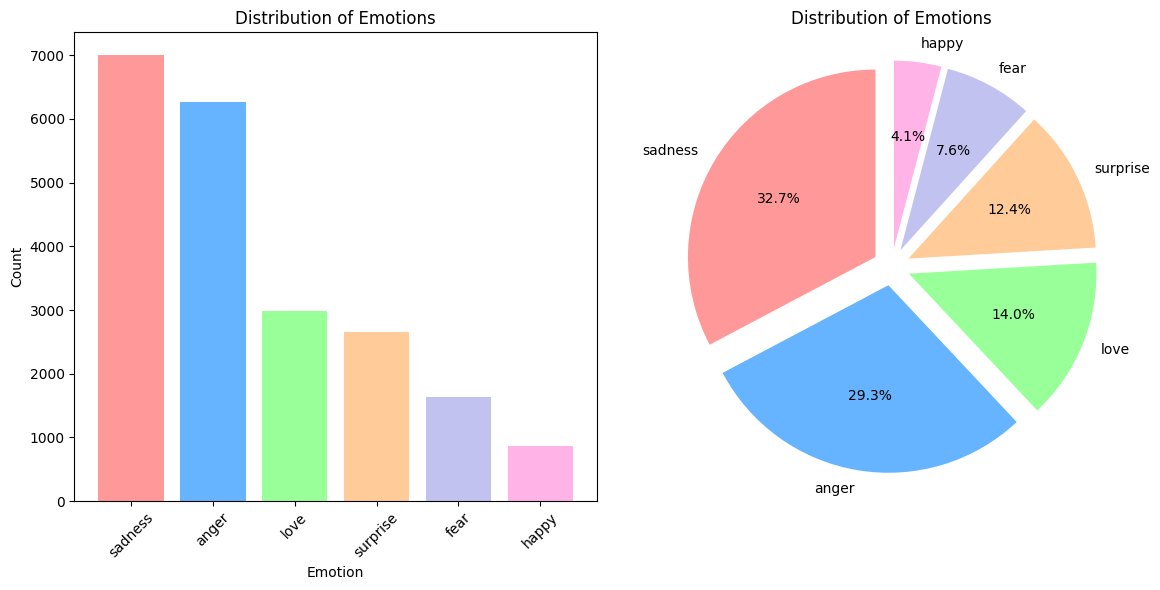

In [ ]:
class Analysis():
    def __init__(self, figsize=(12, 6)):
        self.figsize = figsize

    def plot_bar_pie_chart(self, dataframe, column_name, explode, colors):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=self.figsize)
        labels = list(dataframe[column_name].unique())
        sizes = list(dataframe[column_name].value_counts())

        ax1.bar(labels, sizes, color=colors)
        ax1.set_title('Distribution of Emotions')
        ax1.set_xlabel('Emotion')
        ax1.set_ylabel('Count')
        ax1.tick_params(axis='x', rotation=45)

        ax2.pie(sizes, labels=labels,explode=explode, colors=colors, autopct='%1.1f%%', startangle=90)
        ax2.set_title('Distribution of Emotions')


        plt.tight_layout()
        plt.show()

    def create_label_counts_df(self, dataframe, column_name):

        label_counts_df = dataframe[column_name].value_counts().reset_index()
        label_counts_df.columns = ['emotion', 'count']
        return label_counts_df.transpose()

    def __call__ (self, dataframe, column_name, explode, colors):
        print("-"*55)
        display(self.create_label_counts_df(dataframe, column_name))
        print("-"*55)
        self.plot_bar_pie_chart(dataframe, column_name, explode, colors)

analysis = Analysis(figsize=(12, 6))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6']
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
analysis(dataset, 'Emotion', explode, colors)

# **Load Roberta base model**

**cuda**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**Load the pre-trained RoBERTa model for sequence classification with 6 output labels and move it to the specified device.**


In [ ]:
model_name = "roberta-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 6).to(device)
tokenizer = RobertaTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

# **Pipeline for Preprocessing and fine Tune model an Emotion Classification Model**

This Colab cell defines and runs a pipeline for preparing a dataset, cleaning text data, and training a model for emotion classification. The pipeline includes:

1.   Data Import: Load data from a CSV file

2.   Data Cleaning: Apply text processing techniques such as

  *   lowercasing
  *   removing special characters
  *   removing numbers
  *   removing emojis
  *   removing rare words
  *   removing extra
  *   removing empty strings

3.   Data Preprocessing: Tokenize the text and split the data into training, validation, and test sets. Encode the target labels.
4.   Model Training: Train a model with the processed data and evaluate its performance.

The pipeline culminates with saving the trained model. Use the run_pipeline method with your dataset path and model to execute the entire process.


In [ ]:
class Piplines_Prepare_preprocessing_training():
    # Initialize with column names for input text and target emotion
    def __init__(self, input_column_name='Text', traget_column_name='Emotion'):
        self.input_column_name = input_column_name
        self.traget_column_name = traget_column_name

    # Load dataset from a CSV file
    def data_importer(self, path):
        dataset = pd.read_csv(path)

        print("="*50)
        print("step 1: The data loaded successfully :)")
        print("="*50)
        print(dataset.head(5))  # Print the first 5 rows of the dataset for inspection

        return dataset

    # Clean data by applying various text processing functions
    def data_cleaner(self, dataset):
        # Convert all text in the input column to lower case
        def to_lower_case(examples):
            return [text.lower() for text in examples[self.input_column_name]]

        # Remove special characters from the text
        def remove_special_characters(examples):
            return [re.sub(r'[^\w\s]', '', text) for text in examples[self.input_column_name]]

        # Remove all numbers from the text
        def remove_numbers(examples):
            return [re.sub(r'\d+', '', text) for text in examples[self.input_column_name]]

        # Remove emojis from the text
        def remove_emojis(examples):
            return [text.encode('ascii', 'ignore').decode('ascii') for text in examples[self.input_column_name]]

        # Remove extra spaces from the text
        def remove_extra_spaces(examples):
            return [' '.join(text.split()) for text in examples[self.input_column_name]]

        # Remove rare words that occur less than min_freq times
        def remove_rare_words(examples, min_freq=10):
            all_words = [word for text in examples[self.input_column_name] for word in text.split()]
            word_counts = Counter(all_words)
            filtered_texts = [
                ' '.join(word for word in text.split() if word_counts[word] >= min_freq)
                for text in examples[self.input_column_name]
            ]
            return filtered_texts

        # Remove empty strings from the dataset
        def remove_empty_strings(examples):
            non_empty_indices = [i for i, text in enumerate(examples[self.input_column_name]) if text.strip() != '']
            return examples.iloc[non_empty_indices].reset_index(drop=True)

        # Apply all text cleaning functions to the dataset
        dataset[self.input_column_name] = to_lower_case(dataset)
        dataset[self.input_column_name] = remove_special_characters(dataset)
        dataset[self.input_column_name] = remove_numbers(dataset)
        dataset[self.input_column_name] = remove_emojis(dataset)
        dataset[self.input_column_name] = remove_rare_words(dataset, min_freq=10)
        dataset[self.input_column_name] = remove_extra_spaces(dataset)
        dataset = remove_empty_strings(dataset)

        print("="*50)
        print("step 2: The data was cleaned successfully :)")
        print("="*50)
        print(dataset.head(5))  # Print the first 5 rows of the cleaned dataset

        return dataset

    # Tokenize data and prepare datasets for training, validation, and testing
    def data_preprocessor(self, dataset, tokenizer):
        # Tokenize the text and return the encoding
        def tokenize_function(examples):
            encoding = tokenizer(examples[self.input_column_name], max_length=100, padding="max_length", truncation=True)
            return {self.input_column_name: encoding['input_ids'], 'attention_mask': encoding['attention_mask']}

        # Encode target labels into numerical values
        le = LabelEncoder()
        dataset[self.traget_column_name] = le.fit_transform(dataset[self.traget_column_name])
        with open(r"FineTuned_roberta\label_encoder_object.pkl", 'wb') as f:
            pickle.dump(le, f)  # Save the label encoder to a file

        # Split the dataset into training, validation, and test sets
        train_data, temp_data = train_test_split(dataset, test_size=0.05, shuffle=True)
        validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        # Convert pandas DataFrames to Hugging Face Datasets
        train_dataset = Dataset.from_pandas(train_data)
        validation_dataset = Dataset.from_pandas(validation_data)
        test_dataset = Dataset.from_pandas(test_data)

        dataset_dict = DatasetDict({
            'train': train_dataset,
            'validation': validation_dataset,
            'test': test_dataset})

        dataset_dict = dataset_dict.remove_columns('__index_level_0__')  # Remove unnecessary columns

        # Tokenize datasets
        tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
        tokenized_datasets = tokenized_datasets.rename_column(self.traget_column_name, "labels")
        tokenized_datasets = tokenized_datasets.rename_column(self.input_column_name, "input_ids")

        # Print a sample of the tokenized data for inspection
        print(tokenized_datasets['train'][5:10]['input_ids'])
        print(tokenized_datasets['train'][5:10]['labels'])
        print(tokenized_datasets['validation'][5:10]['input_ids'])
        print(tokenized_datasets['validation'][5:10]['labels'])
        print(tokenized_datasets['test'][5:10]['input_ids'])
        print(tokenized_datasets['test'][5:10]['labels'])

        print("="*52)
        print("step 3: Data preprocessing was done successfully :)")
        print("="*52)
        print(le.classes_)  # Print the classes in the label encoder
        print(dataset_dict)  # Print the dataset dictionary
        print(tokenized_datasets)  # Print the tokenized datasets
        return tokenized_datasets, le

    # Define training parameters and train the model
    def model_trainer(self, dataset, model):
        # Function to compute metrics for evaluation
        def compute_metrics_test(p):
            pred, labels = p
            pred = np.argmax(pred, axis=1)
            accuracy = accuracy_score(y_true=labels, y_pred=pred)
            recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
            precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
            f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
            print(classification_report(labels, pred))
            return {"Test accuracy": accuracy,
                    "Test precision": precision,
                    "Test recall": recall,
                    "Test f1": f1}

        # Set up training arguments
        batch_size = 32
        model_name = r"H:\finetuned-emotion"
        training_args = TrainingArguments(
            output_dir=model_name,
            num_train_epochs = 4,
            learning_rate=2e-5,
            per_device_train_batch_size=batch_size,
            weight_decay=0.01,
            evaluation_strategy ='epoch',
            disable_tqdm=False
        )

        # Initialize Trainer with model, arguments, and datasets
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=dataset["train"],
            eval_dataset=dataset["validation"],
            compute_metrics=compute_metrics_test,
        )
        print("="*52)
        print("step 4: Start training Model :)")
        print("="*52)

        trainer.train()  # Start training the model
        print("model saved in:", model_name)
        print("="*52)
        print("Finish training Model :)")
        print("="*52)

        return trainer

    # Evaluate the model on the test dataset
    def model_evaluation(self, trainer, dataset):
        print("="*52)
        print("step 5: Start evaluation model :)")
        print("="*52)

        test_results = trainer.evaluate(eval_dataset=dataset['test'])

        print("-"*45)
        print("Test evaluation results:")
        print("-"*45)
        print(test_results)  # Print the results of the model evaluation
        print("="*52)

    # Run the entire pipeline from data import to model evaluation
    def run_pipline(self, df_path, model, tokenizer):
        dataset = self.data_importer(df_path)
        dataset = self.data_cleaner(dataset)
        dataset, _ = self.data_preprocessor(dataset, tokenizer)
        trainer = self.model_trainer(dataset, model)
        self.model_evaluation(trainer, dataset)


# **Run the Pipeline:**

In [ ]:
pipeline = Piplines_Prepare_preprocessing_training()
pipeline.run_pipline(
    "/content/Emotion_final.csv",
    model,
    tokenizer
  )

step 1: The data loaded successfully :)
                                                Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
step 2: The data was cleaned successfully :)
                                                Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so hopefu...  sadness
2            im a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the i will k...     love
4                               i am feeling grouchy    anger


Map:   0%|          | 0/20386 [00:00<?, ? examples/s]

Map:   0%|          | 0/536 [00:00<?, ? examples/s]

Map:   0%|          | 0/537 [00:00<?, ? examples/s]

[[0, 757, 2157, 33554, 4356, 157, 2542, 9, 5, 8, 114, 51, 342, 24, 15, 5, 2799, 51, 236, 7, 304, 24, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 627, 3835, 56, 295, 90, 57, 350, 4343, 59, 14, 410, 3238, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 118, 619, 35370, 5384, 636, 8, 562, 1164, 227, 127, 2473, 8, 939, 95, 8578, 47320, 244, 23, 70, 24, 817, 24, 3007, 98, 4356, 667, 7, 28, 6327, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Test accuracy,Test precision,Test recall,Test f1
1,0.281900,0.216675,0.908582,0.919359,0.908582,0.910054
2,0.203100,0.169951,0.930970,0.932784,0.930970,0.930854
3,0.156100,0.200063,0.919776,0.922547,0.919776,0.917931
4,0.113300,0.180941,0.917910,0.921041,0.917910,0.917104


              precision    recall  f1-score   support

           0       0.91      0.91      0.91        76
           1       0.85      0.95      0.90        77
           2       0.99      0.88      0.93       171
           3       0.64      1.00      0.78        29
           4       0.95      0.94      0.94       162
           5       0.81      0.62      0.70        21

    accuracy                           0.91       536
   macro avg       0.86      0.88      0.86       536
weighted avg       0.92      0.91      0.91       536

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        76
           1       0.87      0.97      0.92        77
           2       0.95      0.94      0.94       171
           3       0.74      0.79      0.77        29
           4       0.97      0.97      0.97       162
           5       0.88      0.71      0.79        21

    accuracy                           0.93       536
   macro avg       0.90

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        81
           1       0.80      1.00      0.89        65
           2       0.96      0.96      0.96       165
           3       0.81      0.78      0.79        32
           4       1.00      0.96      0.98       167
           5       1.00      0.67      0.80        27

    accuracy                           0.94       537
   macro avg       0.92      0.89      0.90       537
weighted avg       0.94      0.94      0.94       537

---------------------------------------------
Test evaluation results:
---------------------------------------------
{'eval_loss': 0.09950002282857895, 'eval_Test accuracy': 0.9385474860335196, 'eval_Test precision': 0.9441510504930402, 'eval_Test recall': 0.9385474860335196, 'eval_Test f1': 0.9382090347121557, 'eval_runtime': 3.0978, 'eval_samples_per_second': 173.349, 'eval_steps_per_second': 21.951, 'epoch': 4.0}


# **Some predictions**

In [ ]:
with open(r"FineTuned_roberta\label_encoder_object.pkl", 'rb') as f:
    le = pickle.load(f)

In [ ]:
texts = ["i will go to school", "i am sad", "wow its amazing", "i will cray", "hhhhhh, good man", "omg, incrediable"]
for text in texts:
  input_encoded = tokenizer(text, return_tensors='pt').to(device)
  with torch.no_grad():
    outputs = model(**input_encoded)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    print(f"sentence: {text} ===> {le.classes_[pred]}")

sentence: i will go to school ===> happy
sentence: i am sad ===> sadness
sentence: wow its amazing ===> surprise
sentence: i will cray ===> sadness
sentence: hhhhhh, good man ===> happy
sentence: omg, incrediable ===> surprise
